In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import sys
print(sys.path)
sys.path.insert(0, "/Users/garciaj42/code/MLFinance/claude")

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import asyncio
from claude import IntegratedMarketCollector
from train_model import build_model

collector = IntegratedMarketCollector(
    reddit_client_id='vaANhmFSKa7HMntggd324A',
    reddit_client_secret='6-gPDtvtoqKLaS9_19hm_3faAhB1IA',
    reddit_user_agent='collector',
    fred_api_key='c44011f35ea9b58dc265ab237efaa525',
    twitter_bearer_token='AAAAAAAAAAAAAAAAAAAAAGDQwgEAAAAAAn2onqKyAxz7MIQHabh8kRTnXdI%3DFlVh9CHWs57VIhAyF29lCX9FAkrFyyA8mFOns3scoKtAqmlfLy'  # Optional
)

async def run():
    return await collector.run_data_collection(duration_hours=6.5)

loop = asyncio.get_event_loop()
data = loop.run_until_complete(run())

print(data)

ModuleNotFoundError: No module named 'claude'

In [ ]:
model = build_model(features=data, use_cache=False)

Volatility stats:
count    115371.000000
mean          0.047098
std           0.020694
min           0.013048
25%           0.030941
50%           0.040322
75%           0.062179
max           0.121483
Name: close, dtype: float64

Number of non-null values: 115371
Number of events after filtering: 115371
Sample of target values: date_time
2021-05-21 00:11:00    0.039959
2021-05-21 00:31:00    0.039959
2021-05-21 00:56:00    0.039959
2021-05-21 01:18:00    0.039959
2021-05-21 01:40:00    0.039959
Name: close, dtype: float64
T_events length: 172068
Beginning triple_barrier_events at time 2024-12-21 00:44:40.065640
triple_barrier_events
114833
                                     t1      trgt  pt  sl
date_time                                                
2021-05-21 00:11:00 2021-05-28 00:25:00  0.039959   2   1
2021-05-21 00:31:00 2021-05-28 00:37:00  0.039959   2   1
2021-05-21 00:56:00 2021-05-28 01:03:00  0.039959   2   1
2021-05-21 01:18:00 2021-05-28 01:20:00  0.039959   2   1
202

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by RobustScaler.

In [ ]:
model

Model(triple_barrier_events=                                     t1      trgt  pt  sl  side       ret
date_time                                                                
2021-05-21 00:11:00 2021-05-28 00:25:00  0.039959   2   1     0  0.017597
2021-05-21 00:31:00 2021-05-28 00:37:00  0.039959   2   1     0  0.005093
2021-05-21 00:56:00 2021-05-28 01:03:00  0.039959   2   1     0  0.012649
2021-05-21 01:18:00 2021-05-28 01:20:00  0.039959   2   1     0  0.002915
2021-05-21 01:40:00 2021-05-28 01:44:00  0.039959   2   1     0  0.009962
...                                 ...       ...  ..  ..   ...       ...
2024-11-11 07:58:00 2024-11-12 12:59:00  0.035921   2   1    -1 -0.078680
2024-11-11 08:04:00 2024-11-12 12:59:00  0.035921   2   1    -1 -0.080672
2024-11-11 08:11:00 2024-11-12 12:59:00  0.035921   2   1    -1 -0.077108
2024-11-11 08:20:00 2024-11-12 12:59:00  0.035921   2   1    -1 -0.074380
2024-11-11 08:26:00 2024-11-12 12:59:00  0.035921   2   1    -1 -0.073529

[114829 r

In [ ]:
from validate import _split_data

X_train, X_test = _split_data(model.X_clean, "2023-01-01")
y_train, y_test = _split_data(model.y_size, "2023-01-01")

First date in data: 2021-06-07 00:02:00
Last date in data: 2024-08-26 23:59:00
Split date: 2023-01-01 00:00:00
Training samples: 3556, Testing samples: 3182
First date in data: 2021-06-07 00:02:00
Last date in data: 2024-08-26 23:59:00
Split date: 2023-01-01 00:00:00
Training samples: 3556, Testing samples: 3182


In [ ]:
X_train

,tick_num,cum_buy_volume,cum_ticks,cum_dollar_value,GDP,UNRATE,CPIAUCSL,FEDFUNDS,T10Y2Y,BAMLH0A0HYM2,...,HOUST_PCT_CHG,HOUST_PCT_CHG_4,HOUST_VOL_4,HOUST_ZSCORE_4,HOUST_TREND_4,RSAFS_PCT_CHG,RSAFS_PCT_CHG_4,RSAFS_VOL_4,RSAFS_ZSCORE_4,RSAFS_TREND_4
date_time,,,,,,,,,,,,,,,,,,,,,
2021-06-07 00:02:00,635993,16893.25,10,1.783267e+08,23368.861,5.9,270.664,0.08,1.41,3.27,...,0.0,0.164179,0.024906,0.760692,0.000093,0.0,0.119959,0.012118,0.566617,0.000068
2021-06-07 00:17:00,636008,25336.00,8,1.426308e+08,23368.861,5.9,270.664,0.08,1.41,3.27,...,0.0,0.164179,0.024906,0.760692,0.000093,0.0,0.119959,0.012118,0.566617,0.000068
2021-06-07 00:23:00,636014,21120.25,6,1.070383e+08,23368.861,5.9,270.664,0.08,1.41,3.27,...,0.0,0.164179,0.024906,0.760692,0.000093,0.0,0.119959,0.012118,0.566617,0.000068
2021-06-07 00:31:00,636022,12671.75,8,1.427332e+08,23368.861,5.9,270.664,0.08,1.41,3.27,...,0.0,0.164179,0.024906,0.760692,0.000093,0.0,0.119959,0.012118,0.566617,0.000068
2021-06-07 00:36:00,636027,0.00,5,8.919610e+07,23368.861,5.9,270.664,0.08,1.41,3.27,...,0.0,0.164179,0.024906,0.760692,0.000093,0.0,0.119959,0.012118,0.566617,0.000068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-19 15:24:00,1183022,34496.75,20,2.936414e+08,26734.277,3.5,298.812,4.10,-0.68,4.67,...,0.0,-0.118421,0.007512,-1.946164,-0.000067,0.0,-0.012402,0.002219,-1.630303,-0.000007
2022-12-19 16:17:00,1183075,42290.50,21,3.102493e+08,26734.277,3.5,298.812,4.10,-0.68,4.67,...,0.0,-0.118421,0.007512,-1.946164,-0.000067,0.0,-0.012402,0.002219,-1.630303,-0.000007
2022-12-19 16:40:00,1183098,46089.25,23,3.392275e+08,26734.277,3.5,298.812,4.10,-0.68,4.67,...,0.0,-0.118421,0.007512,-1.946164,-0.000067,0.0,-0.012402,0.002219,-1.630303,-0.000007


In [ ]:
X_test

,tick_num,cum_buy_volume,cum_ticks,cum_dollar_value,GDP,UNRATE,CPIAUCSL,FEDFUNDS,T10Y2Y,BAMLH0A0HYM2,...,HOUST_PCT_CHG,HOUST_PCT_CHG_4,HOUST_VOL_4,HOUST_ZSCORE_4,HOUST_TREND_4,RSAFS_PCT_CHG,RSAFS_PCT_CHG_4,RSAFS_VOL_4,RSAFS_ZSCORE_4,RSAFS_TREND_4
date_time,,,,,,,,,,,,,,,,,,,,,
2023-02-06 01:00:00,1227452,28929.75,13,2.219824e+08,27164.359,3.6,301.509,4.57,-0.81,3.99,...,0.0,-0.025000,0.007448,0.515602,-0.000014,0.0,0.006874,0.004921,0.691710,0.000004
2023-02-06 03:15:00,1227587,28924.50,10,1.706816e+08,27164.359,3.6,301.509,4.57,-0.81,3.99,...,0.0,-0.025000,0.007448,0.515602,-0.000014,0.0,0.006874,0.004921,0.691710,0.000004
2023-02-06 04:25:00,1227657,12364.75,9,1.528417e+08,27164.359,3.6,301.509,4.57,-0.81,3.99,...,0.0,-0.025000,0.007448,0.515602,-0.000014,0.0,0.006874,0.004921,0.691710,0.000004
2023-02-06 04:40:00,1227672,8248.50,8,1.359446e+08,27164.359,3.6,301.509,4.57,-0.81,3.99,...,0.0,-0.025000,0.007448,0.515602,-0.000014,0.0,0.006874,0.004921,0.691710,0.000004
2023-02-06 05:01:00,1227693,8230.00,8,1.354216e+08,27164.359,3.6,301.509,4.57,-0.81,3.99,...,0.0,-0.025000,0.007448,0.515602,-0.000014,0.0,0.006874,0.004921,0.691710,0.000004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-26 23:23:00,1779347,22542.25,10,3.175463e+08,29349.924,4.2,314.121,5.33,-0.09,3.15,...,0.0,0.034981,0.010292,1.309144,0.000020,0.0,0.009913,0.001360,1.063305,0.000006
2024-08-26 23:33:00,1779357,33805.75,10,3.174421e+08,29349.924,4.2,314.121,5.33,-0.09,3.15,...,0.0,0.034981,0.010292,1.309144,0.000020,0.0,0.009913,0.001360,1.063305,0.000006
2024-08-26 23:43:00,1779367,33807.25,10,3.174266e+08,29349.924,4.2,314.121,5.33,-0.09,3.15,...,0.0,0.034981,0.010292,1.309144,0.000020,0.0,0.009913,0.001360,1.063305,0.000006


In [ ]:
y_train

date_time
2021-06-07 00:02:00    1.0
2021-06-07 00:17:00    1.0
2021-06-07 00:23:00    1.0
2021-06-07 00:31:00    1.0
2021-06-07 00:36:00    1.0
                      ... 
2022-12-19 15:24:00    1.0
2022-12-19 16:17:00    1.0
2022-12-19 16:40:00    1.0
2022-12-19 16:59:00    1.0
2022-12-19 22:06:00    1.0
Name: label, Length: 3556, dtype: float64

In [ ]:
y_test

date_time
2023-02-06 01:00:00    1.0
2023-02-06 03:15:00    1.0
2023-02-06 04:25:00    1.0
2023-02-06 04:40:00    1.0
2023-02-06 05:01:00    1.0
                      ... 
2024-08-26 23:23:00    1.0
2024-08-26 23:33:00    1.0
2024-08-26 23:43:00    1.0
2024-08-26 23:50:00    1.0
2024-08-26 23:59:00    1.0
Name: label, Length: 3182, dtype: float64

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from FinancialMachineLearning.sample_weights.bootstrapping import *

class SequentialRandomForestClassifier(RandomForestClassifier):
    def _generate_sample_indices(self, random_state, n_samples):
        """Generate bootstrap sample indices with sequential bootstrap method."""
        random_instance = random_state  # get the RandomState instance
        
        ind_mat = get_indicator_matrix(
            model.triple_barrier_events.index.to_series(),
            model.triple_barrier_events['t1']
        )
        
        sample_indices = seq_bootstrap(ind_mat, n_samples)
        
        return sample_indices

In [ ]:
forest = SequentialRandomForestClassifier(
    criterion = 'entropy',
    class_weight = 'balanced_subsample',
    random_state = 42,
    n_estimators = 100,
    max_features = 3, # early stopping
    min_weight_fraction_leaf = 0.05, # early stopping
    oob_score = True
)

forest_fit = forest.fit(
    X = X_train, 
    y = y_train, 
    sample_weight = model.avg_uniq.loc[X_train.index].to_numpy().reshape(1, -1)[0]
)

In [ ]:
from FinancialMachineLearning.cross_validation.cross_validation import get_train_times, get_embargo_times

train_times, test_times = model.triple_barrier_events.loc[:'2019'], model.triple_barrier_events.loc['2019':]

In [ ]:
train_times = get_train_times(train_times['t1'], test_times['t1'])

In [ ]:
train_times.head()

Series([], Name: t1, dtype: datetime64[ns])

In [ ]:
from FinancialMachineLearning.cross_validation.cross_validation import PurgedKFold

purged_k_fold = PurgedKFold(
    n_splits = 10,
    samples_info_sets = model.triple_barrier_events['t1'].loc[X_train.index],
    pct_embargo = 0.01
)

In [ ]:
from FinancialMachineLearning.cross_validation.cross_validation import cross_val_score
from sklearn.metrics import log_loss

cross_validation_score = cross_val_score(
    classifier = forest,
    X = X_train,
    y = y_train,
    sample_weight = model.avg_uniq.loc[X_train.index].to_numpy().reshape(1, -1)[0],
    cv_gen = purged_k_fold,
    scoring = log_loss
)

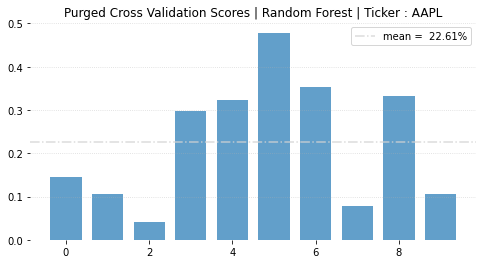

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (8, 4))
ax.bar(
    range(10),
    -cross_validation_score,
    width = 0.75,
    alpha = 0.7,
    edgecolor = 'none'
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5)
plt.axhline(
    y = np.mean(-cross_validation_score),
    ls = '-.',
    color = 'lightgray',
    alpha = 0.8,
    label = f'mean = {np.mean(-cross_validation_score) * 100 : .2f}%'
)
plt.legend()
plt.title('Purged Cross Validation Scores | Random Forest | Ticker : ES')
plt.show()

In [ ]:
samples_info_sets = model.triple_barrier_events['t1'].loc[X_train.index]

In [ ]:
from FinancialMachineLearning.cross_validation.combinatorial import CombinatorialPurgedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

comb_purge_fold = CombinatorialPurgedKFold(
    n_splits = 5,
    n_test_splits = 2, 
    samples_info_sets = samples_info_sets, 
    pct_embargo = 0.06
)

for train_indices, test_indices in comb_purge_fold.split(X_train, y_train):
    X_train_valid, X_test_valid = X_train.iloc[train_indices], X_train.iloc[test_indices]
    y_train_valid, y_test_valid = y_train.iloc[train_indices], y_train.iloc[test_indices]

    clf = RandomForestClassifier(random_state = 42)
    clf.fit(X_train_valid, y_train_valid)
    
    y_pred = clf.predict(X_test_valid)
    accuracy = accuracy_score(y_test_valid, y_pred)
    print(f'Accuracy: {accuracy:.4f}')


Accuracy: 0.9824
Accuracy: 0.9368
Accuracy: 1.0000
Accuracy: 0.9796
Accuracy: 0.9346
Accuracy: 0.9979
Accuracy: 0.9775
Accuracy: 0.9367
Accuracy: 0.9163
Accuracy: 0.9796
